In [408]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [409]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [410]:
import re

In [ ]:
'''
«Задача: построить прогнозирующую отток клиента модель (churn - таргет), включая:
- подготовку данных 
- выбор модели и построение модели
- оценку качества полученной модели
- размышлени€ о применимости модели и полученных результатах.

'''

In [411]:
df = pd.read_csv('data.csv')

**1.Обработка данных**

In [412]:
#Посмотрим на типы данных, проверим есть ли NAN значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
age                                     20468 non-null int64
annualincome                            20468 non-null int64
calldroprate                            20468 non-null float64
callfailurerate                         20468 non-null float64
callingnum                              20468 non-null int64
customerid                              20468 non-null int64
customersuspended                       20468 non-null object
education                               20468 non-null object
gender                                  20468 non-null object
homeowner                               20468 non-null object
maritalstatus                           20468 non-null object
monthlybilledamount                     20468 non-null int64
noadditionallines                       20468 non-null object
numberofcomplaints                      20468 non-null int64
numberofmonthunpaid        

In [413]:
#Поле customerid повторяется
df.head()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,maritalstatus,monthlybilledamount,noadditionallines,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,occupation,penaltytoswitch,state,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,Single,71,\N,0,7,96,Technology Related Job,371,WA,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,Single,8,\N,1,4,14,Technology Related Job,43,WI,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,Single,16,\N,0,2,55,Technology Related Job,403,KS,216,144,No,No,0.48,3122,624,0,2015,1


В результате просмотра данных, оказалось, что строки с одним и тем же customerid меняется только в столбцах 'totalcallduration', 'avgcallduration'

In [41]:
#Посмотрим на отличия 

check = df[14:19][['customerid','month', 'totalcallduration', 'avgcallduration']].groupby(['customerid','month'])
check.first()

totalcallduration  avgcallduration
customerid month                                    
8          1                   2446              815
           2                   4882              813
9          1                   2065              516
           2                   2802              560
           3                    268              268

Необходимо избавиться от дубликатов в выборке, но и не потерять данные по 'totalcallduration' и 'avgcallduration'. Поэтому суммируем данные по 'totalcallduration' и 'avgcallduration' за все месяцы по каждому customerid и внесем их в базу

In [414]:
#Сложим общее количество totalcallduration

df_call_duration = df[['customerid','totalcallduration']]
dict_call_duration = {}
for i, v in df_call_duration.iterrows():
    if v[0] in dict_call_duration:
        dict_call_duration[v[0]] = dict_call_duration.get(v[0]) + v[1]
    else:
        dict_call_duration[v[0]] = v[1]

In [415]:
#Найдем сумму средних значений - avgcallduration

df_avg_duration = df[['customerid','avgcallduration']]
dict_avg_duration = {}
for i, v in df_avg_duration.iterrows():
    if v[0] in dict_avg_duration:
        dict_avg_duration[v[0]] = dict_avg_duration.get(v[0]) + v[1]
    else:
        dict_avg_duration[v[0]] = v[1]

In [416]:
#Сделаем копию df и уберем дубликаты, оставив последнее значение, чтобы у нас было общее количество месяцев

df1 = df.copy()
df1.drop_duplicates(subset ="customerid", keep = 'last', inplace = True) 

In [417]:
#Удалим старые столбцы 'totalcallduration' и 'avgcallduration' 
df1 = df1.drop(['totalcallduration', 'avgcallduration'], axis=1)

# Добавим новые столбцы totalcallduration и avgcallduration по ключу customerid
df1['totalcallduration'] = df1['customerid'].map(dict_call_duration)
df1['sumavgcallduration'] = df1['customerid'].map(dict_avg_duration)

In [418]:
#Добавим признак со средним значением 'avgcallduration' с учетом количества месяцев 
df1['avgcallduration'] = df1['sumavgcallduration']/df1['month']

Заменим длинные значения в 'education'  и 'occupation' на более короткие

In [419]:
#Заменим длинное названия профессии на более короткое 

education_new =[]
for i in df1.education:
    b = re.search(r'^\w*', i)
    education_new.append(b[0])
df1['education'] = education_new

In [420]:
#Заменим длинное названия профессии на более короткое 
occupation_new =[]
for i in df1.occupation:
    b = re.search(r'^\w*', i)
    if b[0] == 'Non':
        occupation_new.append('Non-technology')
    else:
        occupation_new.append(b[0])
df1['occupation'] = occupation_new

В результате обработки исходных данных в количестве 20468 записей, избавившись от дубликатов, но без потери данных за 3 месяца, мы получили 9525 записей. 

In [423]:
#Выкидываем ненужные столбцы

#'noadditionallines' лишь одно значение '\N' <br>
#'year' лишь одно значение только  '2015'<br>
#'callingnum' номер телефона больше подходит для id, а id у нас уже есть <br>
#'sumavgcallduration' оставим вместо этого признака общее среднее 'avgcallduration


df_ = df1.drop(['noadditionallines','callingnum', 'year', 'sumavgcallduration'], axis=1)

In [424]:
#Поставим customerid в качестве индекса
df_=df_.set_index('customerid')

**2. Исследование данных**

Кто наши клиенты с точки зрения дохода и возраста?

In [425]:
df_[['age', 'annualincome']].describe()

,age,annualincome
count,9525.000000,9525.000000
mean,45.358320,124675.519055
std,19.616188,72182.704410
min,12.000000,4.000000
25%,28.000000,62233.000000
50%,45.000000,124637.000000
75%,62.000000,187388.000000
max,79.000000,249987.000000


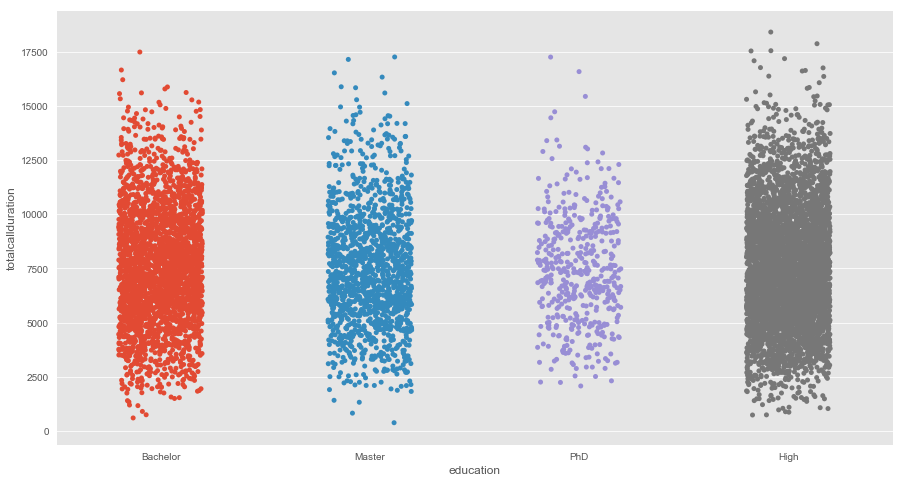

In [426]:
#Как отличается длительность разговора от уровня образования?

plt.figure(figsize=(15,8))
sns.stripplot(data=df_, x='education', y='totalcallduration',  jitter=0.2)

Люди со средним образованием разговаривают больше по длительности, чем с высшим и тем более с уровнем PHD. 

**Отток**

Так как мы предсказываем отток, посмотрим на этот показатель с разных сторон

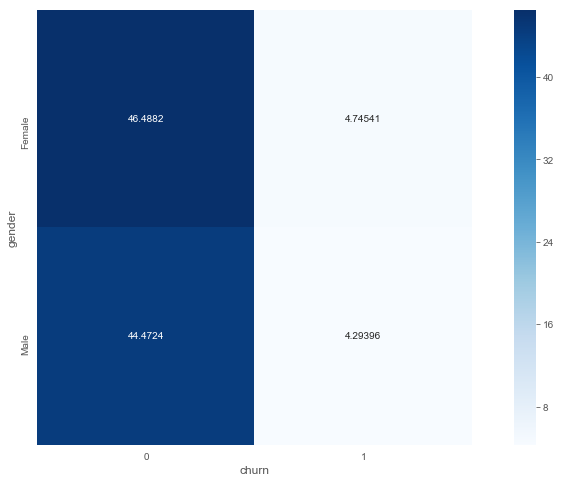

In [427]:
#Зависимость от мужского и женского пола

plt.figure(figsize=(15,8))
gender_churn_norm= pd.crosstab(df_.gender, df_['churn'], normalize=True) * 100
sns.heatmap(gender_churn_norm, cmap='Blues', square=True, annot=True, fmt='g')

Клиенты женского пола более склонны к смене оператора.

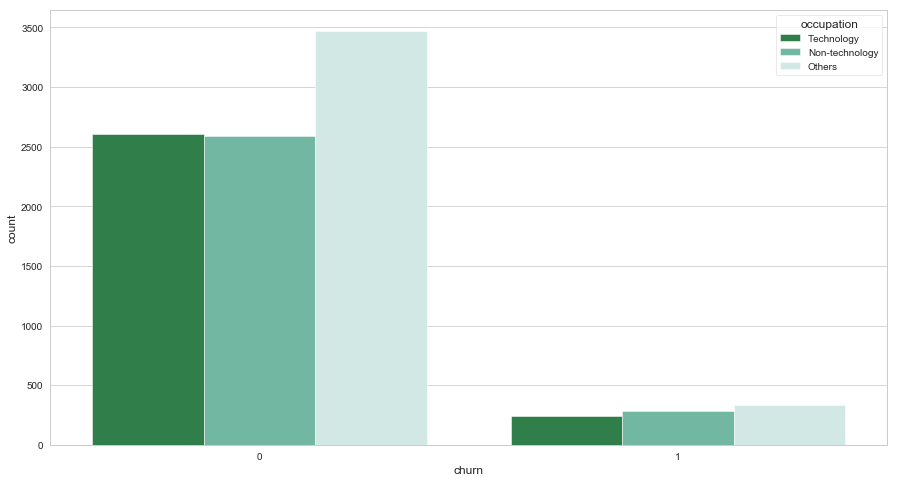

In [428]:
#Как влияет профессиональная деятельность? 

plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.countplot(x='churn',hue='occupation', data=df_, palette='BuGn_r')

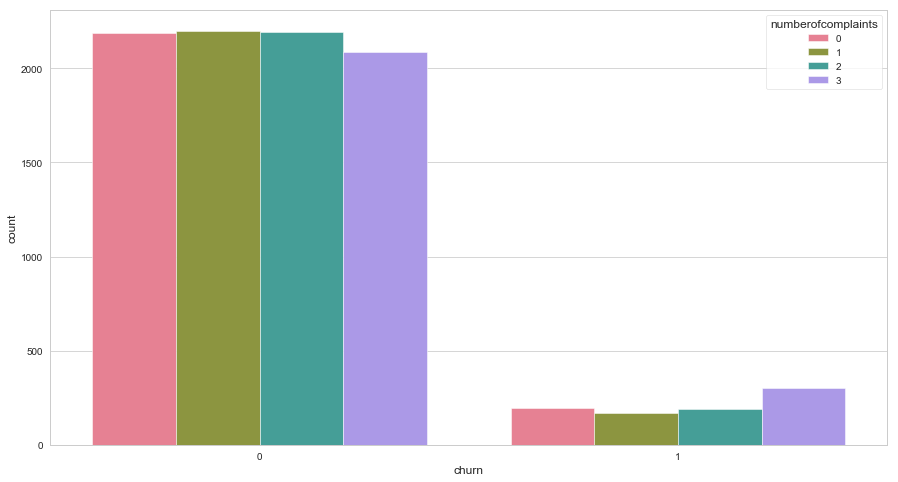

In [429]:
#Как влияет количество жалоб на отток

plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.countplot(x='churn',hue='numberofcomplaints', data=df_, palette='husl')

Количество жалоб выше среди тех, кто перестал пользоваться услугами

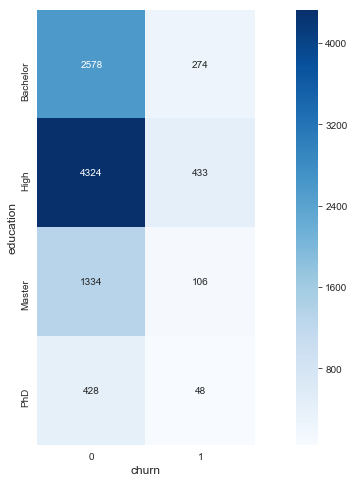

In [430]:
#Посмтрим, как отток распределяется в зависимости от образования

education_churn= pd.crosstab(df_.education, df_['churn'])
plt.figure(figsize=(15,8))
sns.heatmap(education_churn, cmap='Blues', square=True, annot=True, fmt='g')

Самый низкий уровень оттока среди клиентов с уровнем образования "Master"

**Потребление услуг**

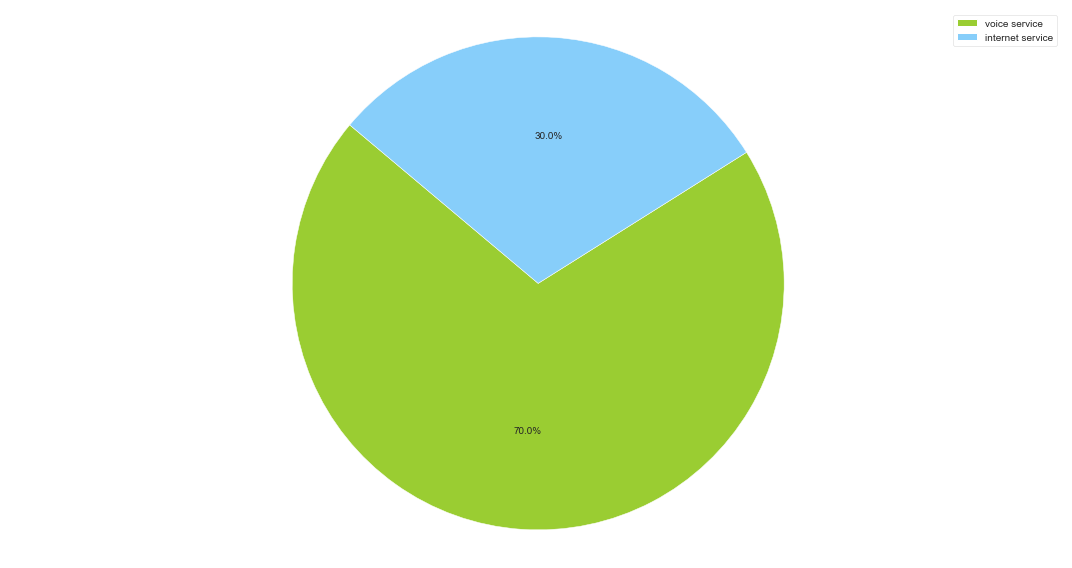

In [431]:
#Как распределяется потребление услуг по объему голосового и интернет трафика

plt.figure(figsize=(15,8))
labels = ['voice service', 'internet service']
internet = len(df_.loc[df_.usesinternetservice=='Yes'])
voice = len(df_.loc[df_.usesvoiceservice=='Yes'])
sizes = [voice, internet]
colors = ['yellowgreen', 'lightskyblue']
plt.pie(sizes, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

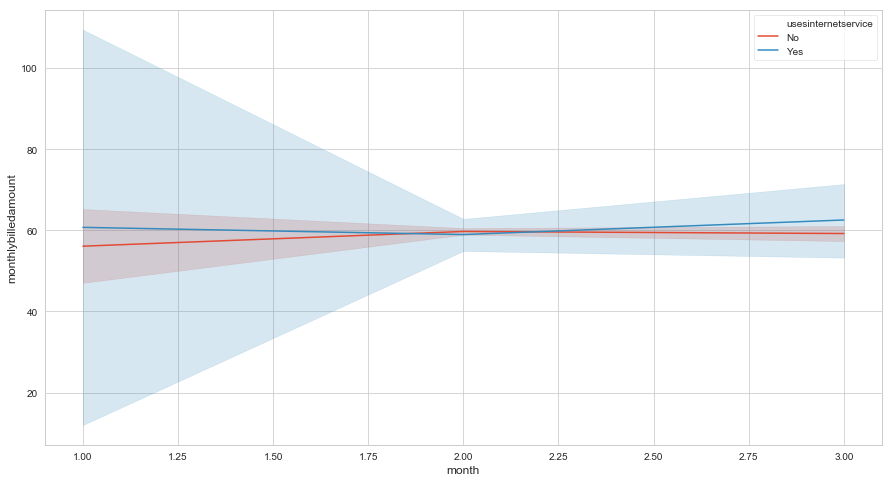

In [432]:
#Посмотрим, как влияет использование интернета на ежемесячный платеж
plt.figure(figsize=(15,8))
sns.lineplot(data=df_, x='month', y='monthlybilledamount', hue ='usesinternetservice')

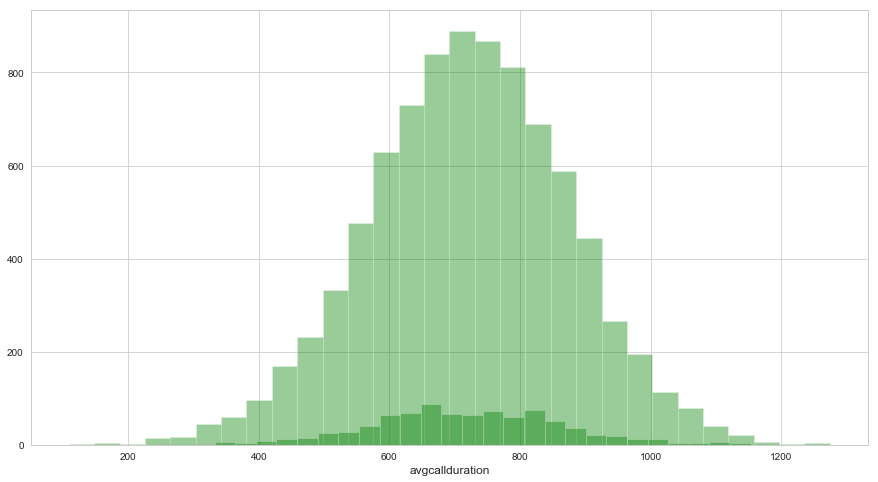

In [433]:
#Сравним распределение средней длительности звонков у текущих и потерянных клиентов

plt.figure(figsize=(15,8))
sns.distplot(df_.loc[(df_['churn'] == 0)]['avgcallduration'],kde=False,color='g',bins=30)
sns.distplot(df_.loc[(df_['churn'] == 1)]['avgcallduration'],kde=False,color='g',bins=30)

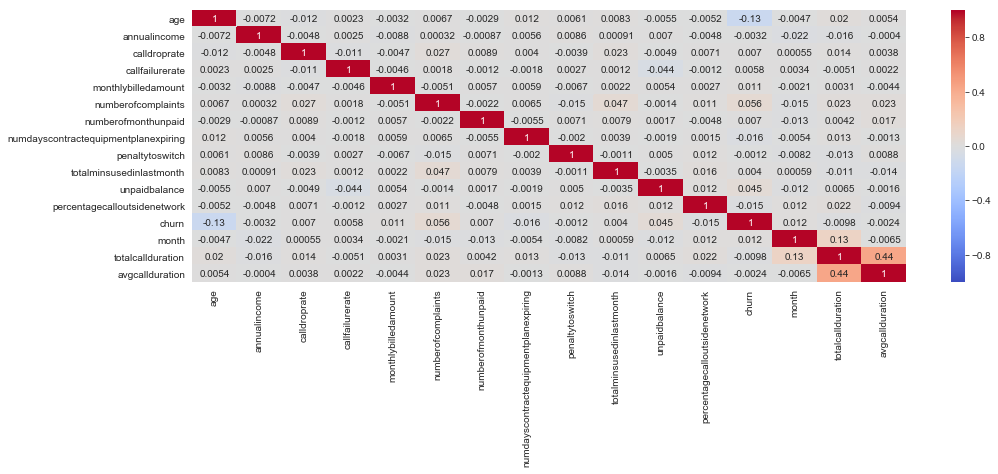

In [434]:
# Посмотрим на корреляцию признаков через heatmap 

plt.figure(figsize = (16,5))
sns.heatmap(df_.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm' )

**3. Подготовка данных для моделирования**

**Переводим в бинарные величины категориальный признаки**

In [435]:
#Выберем признаки, которые будем переводить в бинарный вид 
col_to_encode  = ['gender', 'homeowner', 'education', 'maritalstatus', 'customersuspended', \
           'customersuspended', 'occupation',  'state', 'usesvoiceservice', 'usesinternetservice', 'month' ]

In [436]:
df1 = pd.get_dummies(df_, columns = col_bin)

**Разделим выборку на тестовую и тренировочную**

In [437]:
y = df1['churn']

In [438]:
X = df1.drop('churn', axis=1)

In [439]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [440]:
X_train.head()

,age,annualincome,calldroprate,callfailurerate,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,penaltytoswitch,totalminsusedinlastmonth,unpaidbalance,percentagecalloutsidenetwork,totalcallduration,avgcallduration,gender_Female,gender_Male,homeowner_No,homeowner_Yes,education_Bachelor,education_High,education_Master,education_PhD,maritalstatus_Married,maritalstatus_Single,customersuspended_No,...,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,usesvoiceservice_No,usesvoiceservice_Yes,usesinternetservice_No,usesinternetservice_Yes,month_1,month_2,month_3
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1917,24,23467,0.02,0.00,67,0,5,31,379,406,194,0.28,6623,811.5,1,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
6718,77,212393,0.07,0.03,33,0,3,87,239,5,180,0.11,9206,600.0,1,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
8060,22,79884,0.01,0.03,25,1,6,84,302,170,239,0.07,4053,828.0,1,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
3063,63,115177,0.01,0.02,9,1,6,81,76,76,72,0.31,4501,449.5,1,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
5416,59,158961,0.02,0.02,39,2,4,76,471,232,47,0.80,5989,718.5,0,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0


**Стандартизируем небинарные величины через Z-преобразование в тренировочной и отдельно в тестовой выборке**

In [441]:
training_to_scale = X_train.loc[:, 'age':'avgcallduration']

In [442]:
#бинарные признаки из обучающей выборки, которые мы не будем стандартизировать
training_binary = X_train.loc[:, 'gender_Female':]

In [443]:
test_to_scale = X_test.loc[:, 'age':'avgcallduration']

In [444]:
#бинарные признаки из тестовой выборки, которые мы не будем стандартизировать
test_binary = X_test.loc[:, 'gender_Female':]

In [445]:
#numpy array стандартизированных тренировочных данных 
train_scaled  = scaler.fit_transform(training_to_scale) 

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [446]:
#numpy array стандартизированных тестовых данных 
test_scaled  = scaler.fit_transform(test_to_scale) 

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [447]:
training_norm_col_df = pd.DataFrame(train_scaled, index=training_to_scale.index, columns=training_to_scale.columns) 

In [448]:
test_norm_col_df = pd.DataFrame(test_scaled, index=test_to_scale.index, columns=test_to_scale.columns) 

Соединим небинарные и бинарные стандартизированные части выборок 

In [449]:
X_train_1 = pd.concat([training_norm_col_df, training_binary], axis=1, sort=False)

In [450]:
X_test_1 = pd.concat([test_norm_col_df, test_binary], axis=1, sort=False)

**4. Моделирование**

Построим несколько моделей для предсказания и сравним результаты.

**модель 1. LogisticRegression - логистическая регрессия**

In [451]:
logmodel1 = LogisticRegression()

In [452]:
logmodel1.fit(X_train_1,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [453]:
predictions1 = logmodel1.predict(X_test_1)

**Оценка качества**

In [454]:
print(classification_report(y_test,predictions1))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1719
           1       0.00      0.00      0.00       186

   micro avg       0.90      0.90      0.90      1905
   macro avg       0.45      0.50      0.47      1905
weighted avg       0.81      0.90      0.86      1905



/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [455]:
print(confusion_matrix(y_test,predictions1))

[[1719    0]
 [ 186    0]]


In [456]:
accuracy_score(y_test, predictions1, normalize=True, sample_weight=None)

0.9023622047244094

**модель 2. DecisionTreeClassifier - дерево решений**

In [457]:
dtree = DecisionTreeClassifier()

In [458]:
dtree.fit(X_train_1,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [459]:
predictions2 = dtree.predict(X_test_1)

In [460]:
accuracy_score(y_test, predictions2, normalize=True, sample_weight=None)

0.8304461942257217

In [461]:
print(classification_report(y_test,predictions2))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1719
           1       0.16      0.17      0.17       186

   micro avg       0.83      0.83      0.83      1905
   macro avg       0.53      0.54      0.54      1905
weighted avg       0.84      0.83      0.83      1905



**модель 3. KNN метод ближайших соседей**

In [462]:
#Определим оптимальное количество соседей в пределеах от 1 до 26.Основное критерий для отбора будет параметр accuracy 
#количество правильных предсказаний / общее количество предсказаний

k_range = range(1,26)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_1,y_train)
        y_pred=knn.predict(X_test_1)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

In [463]:
#Полученные результаты
scores

{1: 0.8356955380577428,
 2: 0.8981627296587926,
 3: 0.8871391076115486,
 4: 0.9007874015748032,
 5: 0.89501312335958,
 6: 0.9007874015748032,
 7: 0.9007874015748032,
 8: 0.9023622047244094,
 9: 0.9023622047244094,
 10: 0.9023622047244094,
 11: 0.9023622047244094,
 12: 0.9023622047244094,
 13: 0.9023622047244094,
 14: 0.9023622047244094,
 15: 0.9023622047244094,
 16: 0.9023622047244094,
 17: 0.9023622047244094,
 18: 0.9023622047244094,
 19: 0.9023622047244094,
 20: 0.9023622047244094,
 21: 0.9023622047244094,
 22: 0.9023622047244094,
 23: 0.9023622047244094,
 24: 0.9023622047244094,
 25: 0.9023622047244094}

Text(0, 0.5, 'Accuracy на тестовой выборке')

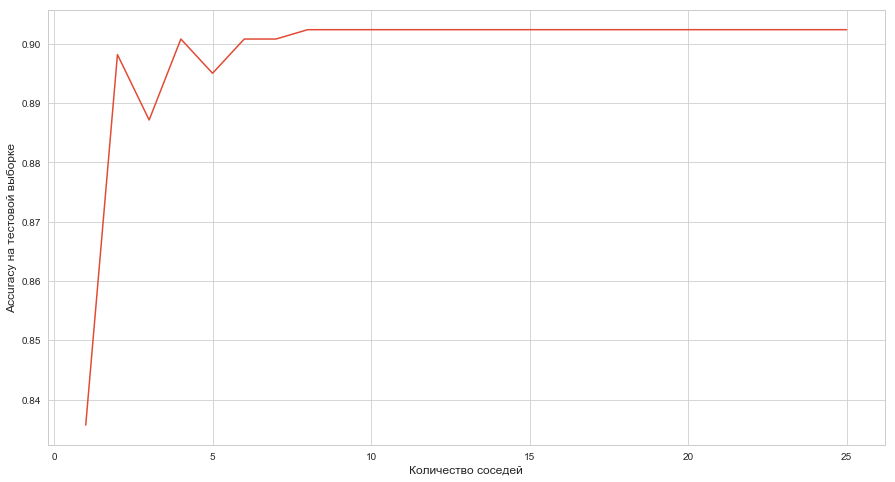

In [464]:
#Визуализиурем accuracy по всему ряду гиперпараметра количества соседей от 1 до 26 

plt.figure(figsize = (15,8))
plt.plot(k_range,scores_list)
plt.xlabel('Количество соседей')
plt.ylabel('Accuracy на тестовой выборке')

In [465]:
#Наиболее оптимальное количество - 10
knn2 = KNeighborsClassifier(n_neighbors = 10)

In [466]:
knn2.fit(X_train_1,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [467]:
prediction_KNN2= knn2.predict(X_test_1)

In [468]:
knn2.score(X_test_1, y_test)

0.9023622047244094

In [469]:
print(classification_report(y_test,prediction_KNN2))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1719
           1       0.00      0.00      0.00       186

   micro avg       0.90      0.90      0.90      1905
   macro avg       0.45      0.50      0.47      1905
weighted avg       0.81      0.90      0.86      1905



/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**модель 4. GradientBoostingClassifier - градиентный бустинг деревьев решений**

In [470]:
#Выберем наиболее оптимальные варианты скорости обучения

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

score_list_GB_test = []
score_list_GB_train = []
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train_1, y_train)
    score_list_GB_test.append (gb.score(X_test_1, y_test))
    score_list_GB_train.append (gb.score(X_train_1, y_train))

Text(0, 0.5, 'Accuracy')

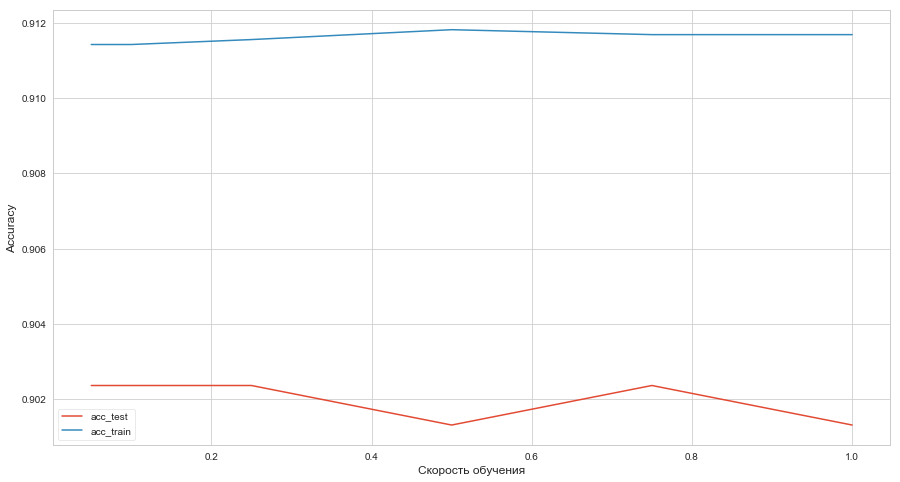

In [471]:
#Посмотрим результаты на графике 

acc_test = score_list_GB_test
acc_train = score_list_GB_train
plt.figure(figsize = (15,8))
plt.plot(learning_rates,acc_test)
plt.plot(learning_rates,acc_train)
plt.gca().legend(('acc_test','acc_train'))
plt.xlabel('Скорость обучения')
plt.ylabel('Accuracy')

In [476]:
#Наиболее оптимальная скорость обучения - 0.7

gb1 = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.7, max_features=2, max_depth = 2, random_state = 0)
gb1.fit(X_train_1, y_train)
gb1.score(X_test_1, y_test)

0.9023622047244094

**5. Оценка оптимальной модели**

In [477]:
#Функция на основе кросс-валидации, которая выдает словарь со средним значением accuracy по каждому алгоритму
def best_model (algo:list, X_train, y_train, folders:int):
    algo_score = {}
    for i in algo:
        cv_scores_train= cross_val_score(i, X_train, y_train, cv = folders)
        algo_score[type(i).__name__] = round(np.mean(cv_scores_train),3)
    return algo_score

In [478]:
algo_list = [logmodel1, dtree, knn2, gb1]

In [479]:
algo_score_training = best_model(algo_list, X_train_1, y_train, 5)

In [480]:
algo_score_test = best_model(algo_list, X_test_1, y_test, 5)

**Объединим результаты по каждой модели на обучающей и тестовой выборке**

In [481]:
df_test_algo = pd.DataFrame(list(algo_score_test.items()), columns=['algo_name', 'test_acc'])
df_train_algo = pd.DataFrame(list(algo_score_training.items()), columns=['algo_name', 'train_acc'])
df_results = df_test_algo.join(df_train_algo.set_index('algo_name'), on='algo_name')
df_results.sort_values('test_acc',ascending=False)

,algo_name,test_acc,train_acc
0,LogisticRegression,0.902,0.911
2,KNeighborsClassifier,0.902,0.911
3,GradientBoostingClassifier,0.896,0.910
1,DecisionTreeClassifier,0.813,0.839


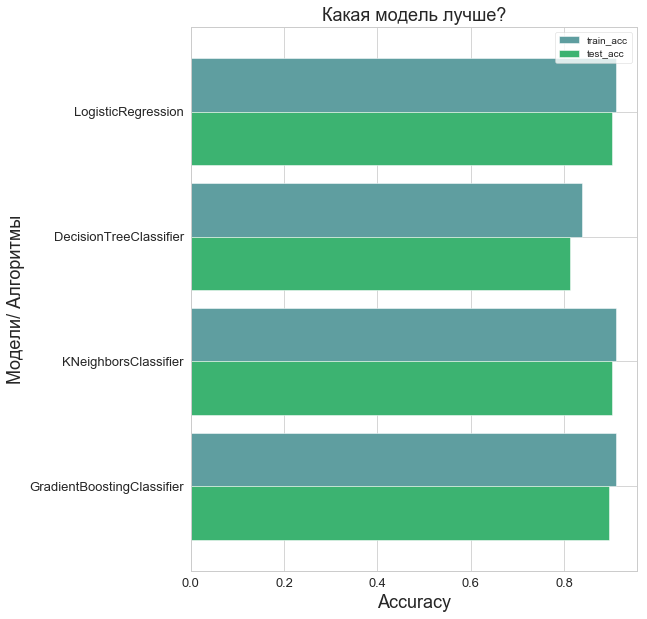

In [482]:
ax = df_results[['train_acc', 'test_acc']].plot(kind='barh', figsize=(8, 10), \
                                                color=['cadetblue', 'mediumseagreen'], fontsize=13, width=0.85)
ax.set_alpha(0.5)
#ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1])
ax.set_yticklabels(df_results.iloc[:,0].values.tolist())
ax.set_title("Какая модель лучше?", fontsize=18)
ax.set_xlabel("Accuracy", fontsize=18)
ax.set_ylabel("Модели/ Алгоритмы", fontsize=18)
ax.invert_yaxis()

**Резюме**

C точки зрения точности предсказания и надежности, выигрывают две модели, основанные на алгоритмах Logistic Regression и KNeighborsClassifier. В дальнейшем, показатели точности могут быть улучшены за счет:

- поиска оптимальных гиперпараметров для каждой модели
- поиска наиболее важных признаков и отсечения неважных
- новых алгоритмов, например использования нейронных сетей
- увеличения числа выборки, так как в результате обработки у нас всего лишь 9525 записей
- увеличения числа признаков выборки за счет новых данных 